In [3]:
import os
import pyspark
conf = pyspark.SparkConf()
conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041') 
conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','4g')
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/21 14:54:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/envs/bigdata/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
spark 

In [20]:
from pyspark.sql.functions import col,exp
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
from pyspark.sql.functions import col, when, count, sum
from pyspark.sql.types import IntegerType, FloatType


# Genre

In [31]:
genre = spark.read.json("../shared/finals/swarali/goodreads_book_genres_initial.json")

In [32]:
genre.show(truncate = False)

+--------+------------------------------------------------------------+
|book_id |genres                                                      |
+--------+------------------------------------------------------------+
|5333265 |{NULL, NULL, NULL, NULL, 1, NULL, NULL, NULL, NULL, NULL}   |
|1333909 |{NULL, NULL, NULL, 219, 5, NULL, NULL, NULL, NULL, NULL}    |
|7327624 |{NULL, NULL, 31, 8, NULL, 1, NULL, 1, NULL, NULL}           |
|6066819 |{NULL, NULL, NULL, 555, NULL, 10, NULL, NULL, 23, NULL}     |
|287140  |{NULL, NULL, NULL, NULL, NULL, NULL, 3, NULL, NULL, NULL}   |
|287141  |{6, NULL, 1, 1, 9, NULL, NULL, NULL, NULL, 1}               |
|378460  |{NULL, NULL, NULL, 2, NULL, NULL, NULL, NULL, NULL, NULL}   |
|6066812 |{16, NULL, 32, 7, NULL, NULL, NULL, NULL, NULL, 8}          |
|34883016|{NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, 3, NULL}   |
|287149  |{NULL, NULL, NULL, NULL, 1, NULL, 24, NULL, NULL, NULL}     |
|6066814 |{NULL, NULL, NULL, 19, 38, 38, NULL, NULL, NULL, NULL}

In [37]:
genre.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- genres: struct (nullable = true)
 |    |-- children: long (nullable = true)
 |    |-- comics, graphic: long (nullable = true)
 |    |-- fantasy, paranormal: long (nullable = true)
 |    |-- fiction: long (nullable = true)
 |    |-- history, historical fiction, biography: long (nullable = true)
 |    |-- mystery, thriller, crime: long (nullable = true)
 |    |-- non-fiction: long (nullable = true)
 |    |-- poetry: long (nullable = true)
 |    |-- romance: long (nullable = true)
 |    |-- young-adult: long (nullable = true)



In [39]:

goodreads_genres_initial = genre

df_pivoted = goodreads_genres_initial.select(
    "book_id",
    expr("coalesce(genres.fiction, 0) as fiction"),
    expr("coalesce(genres.`fantasy, paranormal`, 0) as `fantasy, paranormal`"),
    expr("coalesce(genres.`young-adult`, 0) as `young-adult`"),
    expr("coalesce(genres.`history, historical fiction, biography`, 0) as `history, historical fiction, biography`"),
    expr("coalesce(genres.`mystery, thriller, crime`, 0) as `mystery, thriller, crime`"),
    expr("coalesce(genres.romance, 0) as romance"),
    expr("coalesce(genres.children, 0) as children"),
    expr("coalesce(genres.`non-fiction`, 0) as `non-fiction`"),
    expr("coalesce(genres.`comics, graphic`, 0) as `comics, graphic`"),
    expr("coalesce(genres.poetry, 0) as poetry")
)


In [42]:
df_pivoted.limit(5).toPandas()

,book_id,fiction,"fantasy, paranormal",young-adult,"history, historical fiction, biography","mystery, thriller, crime",romance,children,non-fiction,"comics, graphic",poetry
0,5333265,0,0,0,1,0,0,0,0,0,0
1,1333909,219,0,0,5,0,0,0,0,0,0
2,7327624,8,31,0,0,1,0,0,0,0,1
3,6066819,555,0,0,0,10,23,0,0,0,0
4,287140,0,0,0,0,0,0,0,3,0,0


In [43]:
df_pivoted.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- fiction: long (nullable = false)
 |-- fantasy, paranormal: long (nullable = false)
 |-- young-adult: long (nullable = false)
 |-- history, historical fiction, biography: long (nullable = false)
 |-- mystery, thriller, crime: long (nullable = false)
 |-- romance: long (nullable = false)
 |-- children: long (nullable = false)
 |-- non-fiction: long (nullable = false)
 |-- comics, graphic: long (nullable = false)
 |-- poetry: long (nullable = false)



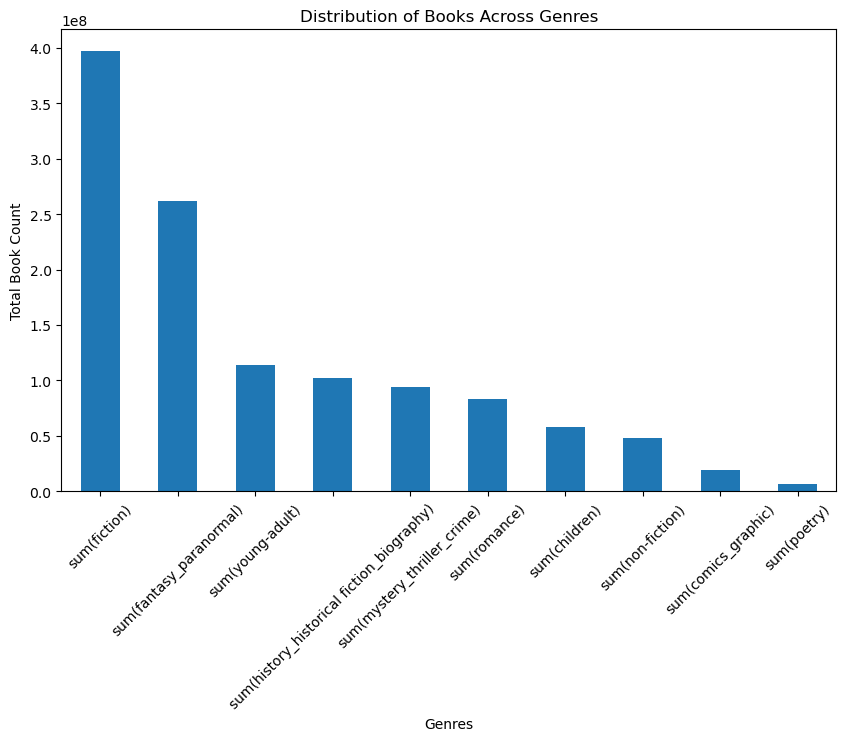

In [52]:

# Calculate the total count for each genre
genre_totals = df_pivoted.select([col(c).alias(c.replace(', ', '_')) for c in df_pivoted.columns[1:]]).groupBy().sum()

# Convert to Pandas for visualization
genre_totals_pd = genre_totals.toPandas()
genre_totals_pd = genre_totals_pd.iloc[0].sort_values(ascending=False)

# Visualization
plt.figure(figsize=(10, 6))
genre_totals_pd.plot(kind='bar')
plt.title('Distribution of Books Across Genres')
plt.xlabel('Genres')
plt.ylabel('Total Book Count')
plt.xticks(rotation=45)
plt.show()


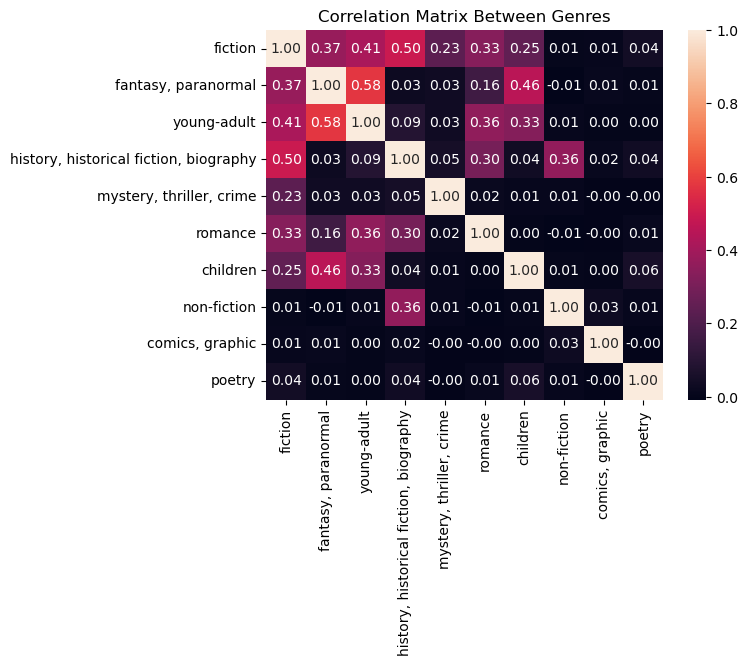

In [48]:

# Assemble a vector of genre columns
assembler = VectorAssembler(inputCols=df_pivoted.columns[1:], outputCol="features")
df_vector = assembler.transform(df_pivoted).select("features")

# Compute the correlation matrix
corr_matrix = Correlation.corr(df_vector, "features").collect()[0][0].toArray()

# Visualization in Seaborn
sns.heatmap(corr_matrix, annot=True, fmt=".2f", xticklabels=df_pivoted.columns[1:], yticklabels=df_pivoted.columns[1:])
plt.title("Correlation Matrix Between Genres")
plt.show()


# Books

In [5]:
book_df = spark.read.json("../shared/finals/swarali/goodreads_books.json")

In [10]:
book_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- author_id: string (nullable = true)
 |    |    |-- role: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- book_id: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- description: string (nullable = true)
 |-- edition_information: string (nullable = true)
 |-- format: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- is_ebook: string (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: string (nullable = true)
 |-- kindle_asin: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- link: string (nullable = true)
 |-- num_pages: string (nullable = true)
 |-- popular_shelves: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- count: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- pub

In [64]:


book_df = book_df.withColumn("average_rating", col("average_rating").cast(FloatType())) \
                 .withColumn("ratings_count", col("ratings_count").cast(IntegerType())) \
                 .withColumn("text_reviews_count", col("text_reviews_count").cast(IntegerType())) \
                 .withColumn("num_pages", col("num_pages").cast(IntegerType())) \
                 .withColumn("publication_year", col("publication_year").cast(IntegerType()))

In [65]:
# Distribution of Average Ratings
average_rating_distribution = book_df.select("average_rating").describe()

In [66]:
average_rating_distribution.toPandas()

,summary,average_rating
0,count,2360131
1,mean,3.865792446739527
2,stddev,0.5406797659688768
3,min,0.0
4,max,5.0


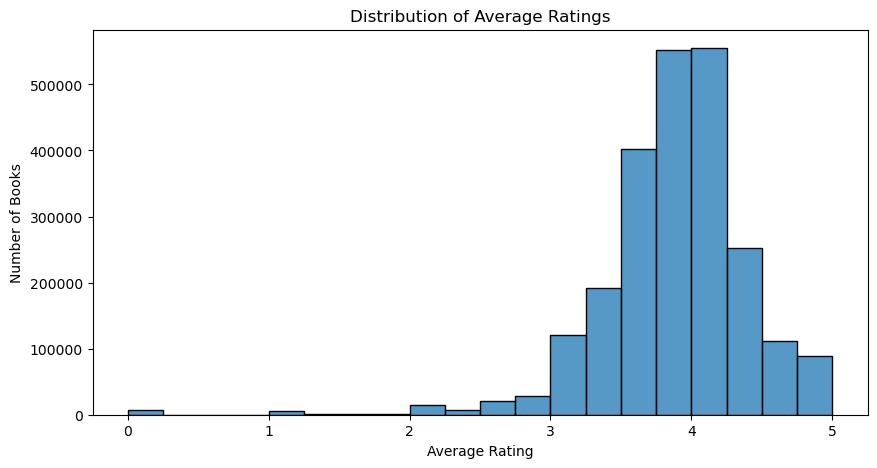

In [67]:
# EDA 1: Average Rating Distribution
average_ratings = book_df.select("average_rating").toPandas()
plt.figure(figsize=(10, 5))
sns.histplot(average_ratings['average_rating'].dropna(), kde=False, bins=20)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Books')
plt.show()

In [68]:
# EDA 2: Count of Books by Format
books_by_format = book_df.groupBy("format").count().orderBy("count", ascending=False)
books_by_format.show(20)

+--------------------+------+
|              format| count|
+--------------------+------+
|           Paperback|894617|
|                    |646754|
|           Hardcover|359563|
|               ebook|188733|
|      Kindle Edition|125566|
|Mass Market Paper...| 42224|
|            Audio CD| 30588|
|           Audiobook| 17387|
|       Audible Audio| 11073|
|               Audio|  8335|
|     Unknown Binding|  8126|
|          Board Book|  4214|
|     Library Binding|  1694|
|          Board book|  1405|
|        Spiral-bound|  1369|
|           paperback|  1366|
|      Audio Cassette|  1152|
|              MP3 CD|  1057|
|       Leather Bound|  1029|
|     Trade Paperback|   641|
+--------------------+------+
only showing top 20 rows



In [70]:
# EDA 3: Ebook Proportion
ebook_proportion = book_df.groupBy("is_ebook").count()

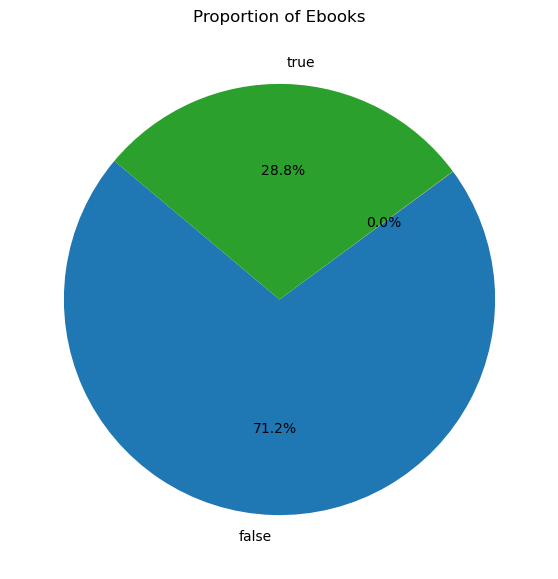

In [71]:
ebook_counts = ebook_proportion.toPandas()
plt.figure(figsize=(7, 7))
plt.pie(ebook_counts['count'], labels=ebook_counts['is_ebook'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Ebooks')
plt.show()

In [74]:
# EDA 4: Relationship Between Ratings Count and Text Reviews Count
ratings_and_reviews = book_df.select("ratings_count", "text_reviews_count")

In [75]:
ratings_and_reviews.show()

+-------------+------------------+
|ratings_count|text_reviews_count|
+-------------+------------------+
|            3|                 1|
|           10|                 6|
|          140|                 7|
|        51184|              3282|
|           15|                 5|
|           46|                 7|
|           12|                 4|
|           98|                 6|
|            5|                 4|
|          986|                39|
|          186|                15|
|          269|                60|
|           11|                 2|
|            9|                 3|
|           77|                19|
|        68157|              2885|
|         7345|               566|
|         6949|               615|
|         1331|               193|
|           72|                22|
+-------------+------------------+
only showing top 20 rows



In [ ]:
ratings_reviews = ratings_and_reviews.toPandas()
sns.jointplot(x='ratings_count', y='text_reviews_count', kind='scatter', data=ratings_reviews)
plt.xlabel('Ratings Count')
plt.ylabel('Text Reviews Count')
plt.show()

In [7]:
# EDA 5: Publication Year Trends
publication_year_trend = book_df.groupBy("publication_year").count().orderBy("publication_year")

In [8]:
publication_year_trend.show()

+----------------+------+
|publication_year| count|
+----------------+------+
|                |599625|
|               0|    12|
|               1|     4|
|              10|     4|
|             100|     1|
|            1000|     2|
|            1005|     1|
|            1007|     1|
|            1012|     6|
|            1013|     1|
|            1014|     3|
|            1015|     2|
|            1016|     4|
|            1017|     5|
|            1025|     2|
|             104|     1|
|            1065|     1|
|            1070|     1|
|            1080|     1|
|            1084|     1|
+----------------+------+
only showing top 20 rows



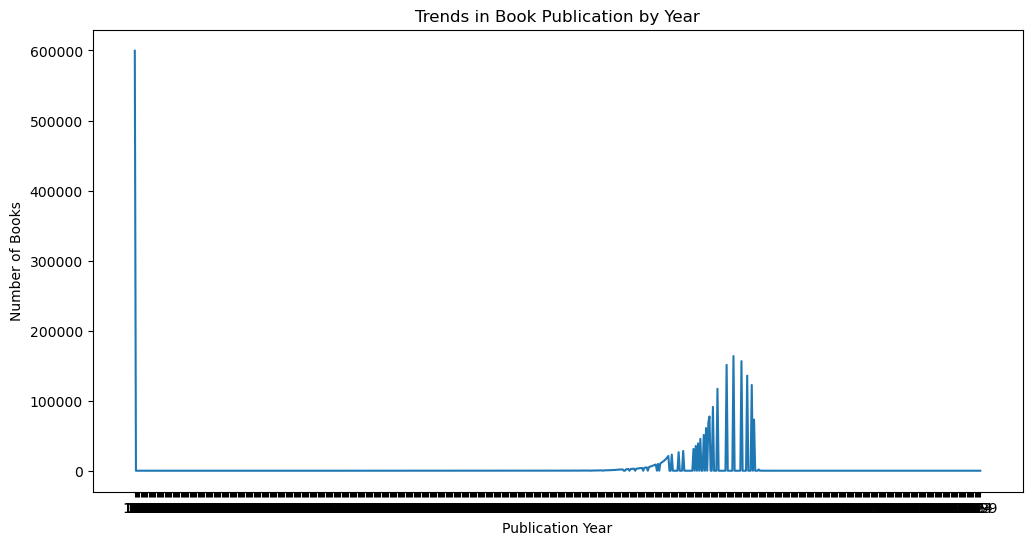

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
publication_years = publication_year_trend.filter(col("count") > 0).toPandas()
plt.figure(figsize=(12, 6))
sns.lineplot(x='publication_year', y='count', data=publication_years)
plt.title('Trends in Book Publication by Year')
plt.xlabel('Publication Year')
plt.ylabel('Number of Books')
plt.show()


In [22]:
# EDA 6: Books by Language
books_by_language = book_df.groupBy("language_code").count().orderBy("count", ascending=False)

In [23]:
books_by_language.show()

+-------------+-------+
|language_code|  count|
+-------------+-------+
|             |1060153|
|          eng| 708457|
|        en-US|  91452|
|        en-GB|  58358|
|          spa|  54524|
|          ita|  50902|
|          ara|  42978|
|          fre|  32046|
|          ger|  30941|
|          ind|  27291|
|          por|  23452|
|           nl|  17497|
|          tur|  14238|
|          per|  11821|
|          fin|  11611|
|          gre|  10024|
|          swe|   9914|
|          cze|   8564|
|        en-CA|   7652|
|          jpn|   7209|
+-------------+-------+
only showing top 20 rows



In [ ]:
# EDA 6: Books by Language
language_counts = book_df.groupBy("language_code").count().toPandas()
language_counts = language_counts[language_counts['count'] > 0]
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='language_code', data=language_counts)
plt.title('Number of Books by Language')
plt.xlabel('Number of Books')
plt.ylabel('Language Code')
plt.show()


# Author

In [26]:
spark_df = spark.read.json("../shared/finals/swarali/goodreads_book_authors.json")

In [27]:
spark_df.show(truncate = False) 

+---------+--------------+-------------------+-------------+------------------+
|author_id|average_rating|name               |ratings_count|text_reviews_count|
+---------+--------------+-------------------+-------------+------------------+
|604031   |3.98          |Ronald J. Fields   |49           |7                 |
|626222   |4.08          |Anita Diamant      |546796       |28716             |
|10333    |3.92          |Barbara Hambly     |122118       |5075              |
|9212     |3.68          |Jennifer Weiner    |888522       |36262             |
|149918   |3.82          |Nigel Pennick      |1740         |96                |
|3041852  |3.89          |Alfred J. Church   |947          |85                |
|215594   |4.17          |Michael Halberstam |23           |6                 |
|19158    |4.18          |Rachel Roberts     |13677        |486               |
|5807700  |3.99          |V.L. Locey         |3130         |986               |
|2983296  |3.48          |Anton Szandor 

In [54]:
spark_df.printSchema()

root
 |-- author_id: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- name: string (nullable = true)
 |-- ratings_count: string (nullable = true)
 |-- text_reviews_count: string (nullable = true)



In [6]:
spark_df.count()

829529

In [7]:
# Average Rating across all Authors
from pyspark.sql.functions import avg

spark_df.select(avg("average_rating")).show()

+-------------------+
|avg(average_rating)|
+-------------------+
|  3.844778892600401|
+-------------------+



In [8]:
# Top 10 authors by rating
from pyspark.sql.functions import desc
spark_df.orderBy(spark_df.ratings_count.desc()).select("name", "ratings_count").limit(10).show()

+--------------------+-------------+
|                name|ratings_count|
+--------------------+-------------+
|      Arthur W. Pink|         9999|
|       Simon Carnell|         9999|
|      Shivaji Sawant|         9999|
|      Nancy Haviland|         9995|
|        Buket Uzuner|         9995|
|      Jillian Lauren|         9995|
|        Judy Melinek|         9993|
|       Steven Heller|         9993|
|    John G. Hartness|         9993|
|Margaret Campbell...|         9992|
+--------------------+-------------+



In [9]:
#Distribution of Text Reviews Count
spark_df.select("text_reviews_count").describe().show()

+-------+------------------+
|summary|text_reviews_count|
+-------+------------------+
|  count|            829529|
|   mean|106.86533080820563|
| stddev|1770.2258283551757|
|    min|                 0|
|    max|             99990|
+-------+------------------+



In [10]:
# Group Authors by average rating
from pyspark.sql.functions import when, col

spark_df.withColumn("rating_group",
              when(col("average_rating") >= 4, "4-5")
              .when(col("average_rating") >= 3, "3-4")
              .otherwise("<3"))\
  .groupBy("rating_group")\
  .count()\
  .orderBy("rating_group")\
  .show()


+------------+------+
|rating_group| count|
+------------+------+
|         3-4|436221|
|         4-5|354072|
|          <3| 39236|
+------------+------+



In [29]:
# Authors with Highest Average Rating
threshold = 1000
spark_df.filter(spark_df.ratings_count > threshold).orderBy(desc("average_rating")).select("name", "average_rating").show()


+------------------+--------------+
|              name|average_rating|
+------------------+--------------+
|       E.J.  Brock|          4.87|
|Crafty Creeper Art|          4.82|
|    Skeleton Steve|          4.82|
|     Savan Kotecha|          4.82|
|          KC Mills|          4.82|
|   Natavia Stewart|          4.82|
|     Brian Simmons|          4.81|
|            Bianca|          4.80|
|   Radhanath Swami|          4.80|
|       A.O. Esther|          4.79|
|         Ilchi Lee|          4.78|
|           KB Cole|          4.78|
|    Steve the Noob|          4.78|
|       Nikki Brown|          4.78|
|     Latoya Nicole|          4.78|
|            Tina J|          4.78|
|   Shvonne Latrice|          4.77|
|       elle kayson|          4.77|
|    Andy Gonsalves|          4.77|
|       Abdu'l-Baha|          4.77|
+------------------+--------------+
only showing top 20 rows



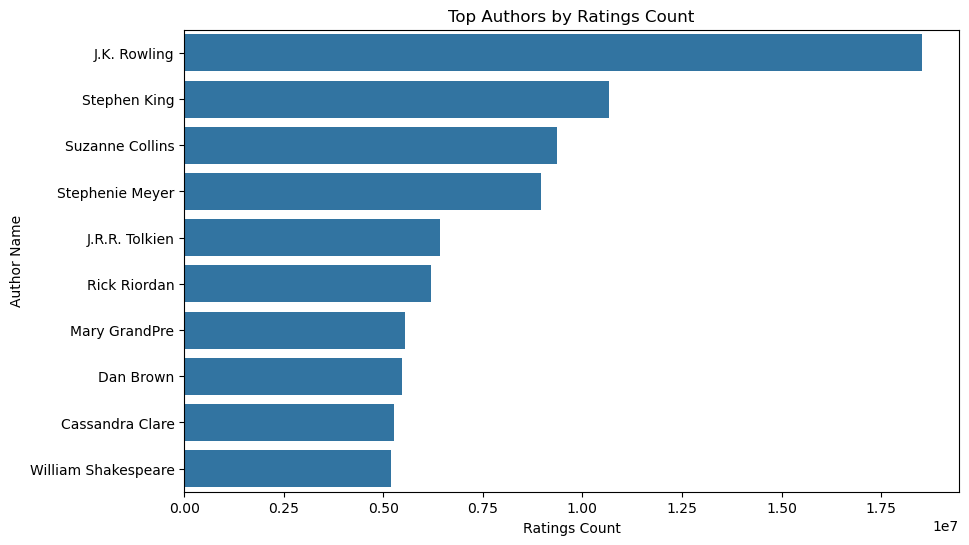

In [59]:
# Top Authors by Ratings Count
top_authors = spark_df.orderBy(col("ratings_count").desc()).limit(10).toPandas()

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='ratings_count', y='name', data=top_authors)
plt.title('Top Authors by Ratings Count')
plt.xlabel('Ratings Count')
plt.ylabel('Author Name')
plt.show()

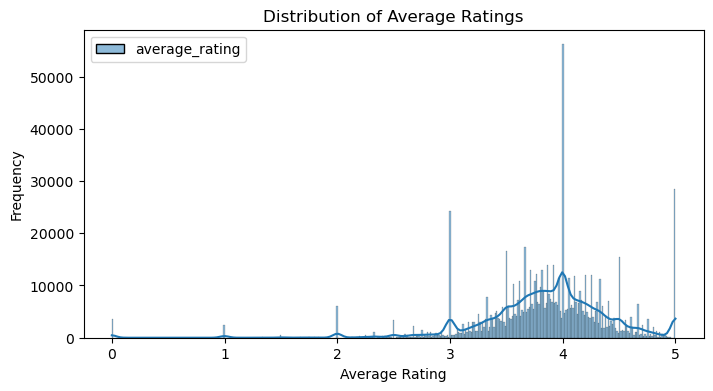

In [58]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns

# Convert necessary columns to numeric
spark_df = spark_df.withColumn("average_rating", col("average_rating").cast("float"))
spark_df = spark_df.withColumn("ratings_count", col("ratings_count").cast(IntegerType()))
spark_df = spark_df.withColumn("text_reviews_count", col("text_reviews_count").cast(IntegerType()))

# 1. Distribution of Average Ratings
average_ratings = spark_df.select('average_rating').toPandas()

# Visualization
plt.figure(figsize=(8, 4))
sns.histplot(average_ratings, kde=True)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

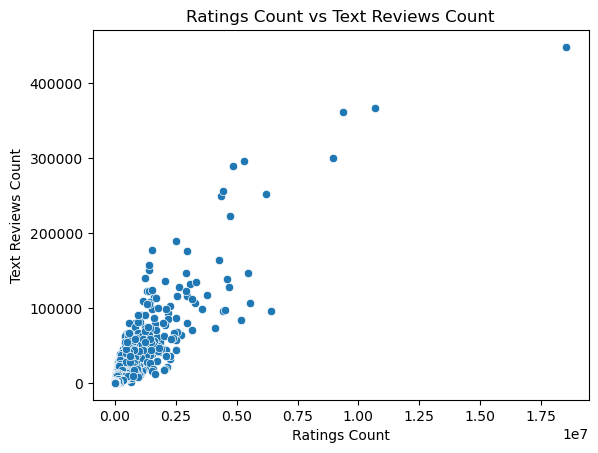

In [60]:
# Relationship Between Ratings Count and Text Reviews Count

sns.scatterplot(data=spark_df.toPandas(), x='ratings_count', y='text_reviews_count')
plt.title('Ratings Count vs Text Reviews Count')
plt.xlabel('Ratings Count')
plt.ylabel('Text Reviews Count')
plt.show()